mkdir -p ~/aiffel/recommendata_iu/data/lastfm-dataset-360K
ln -s ~/data/lastfm-dataset-360K/* ~/aiffel/recommendata_iu/data/lastfm-dataset-360K

### 전처리

In [402]:
import numpy as np
import os
import pandas as pd

#### ratings 파일 전처리 

In [403]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [404]:
# 계산의 편의성과 속도를 위해 
# 3점이상만 남긴다
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [405]:
# rating 컬럼의 이름을 count로 바꾼다#### ratings 파일 전처리 
ratings.rename(columns={'rating':'count'}, inplace=True)

#### movies 파일 전처리 

In [406]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()### MF 모델 구성

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### MF 모델 구성

### 분석

#### ratings에 있는 유니크한 영화 개수, rating에 있는 유니크한 사용자 수

In [407]:
print(f'ratings에 있는 유니크한 영화 개수는 : {ratings.movie_id.nunique()}개 입니다.')
print(f'ratings에 있는 유니크한 사용자 수는 : {ratings.user_id.nunique()}명 입니다.')

ratings에 있는 유니크한 영화 개수는 : 3628개 입니다.
ratings에 있는 유니크한 사용자 수는 : 6039명 입니다.


In [408]:
data = ratings.join(movies, on= 'movie_id', rsuffix = '_2')
data.head()

,user_id,movie_id,count,timestamp,movie_id_2,title,genre
0,1,1193,5,978300760,1211.0,Wings of Desire (Der Himmel über Berlin) (1987),Comedy|Drama|Romance
1,1,661,3,978302109,667.0,Bloodsport 2 (1995),Action
2,1,914,3,978301968,926.0,All About Eve (1950),Drama
3,1,3408,4,978300275,3477.0,Empire Records (1995),Comedy|Drama
4,1,2355,5,978824291,2424.0,You've Got Mail (1998),Comedy|Romance


#### 가장 인기 있는 영화 30개(인기순)

In [409]:
popular_list = data.groupby('title')['user_id'].count().reset_index()
popular_list = popular_list.rename(columns= {'user_id':'audience_number'})

In [410]:
popular_list.columns

Index(['title', 'audience_number'], dtype='object')

In [411]:
popular_list.index

RangeIndex(start=0, stop=3561, step=1)

In [412]:
type(popular_list)

pandas.core.frame.DataFrame

In [413]:
popular_list.sort_values(by = 'audience_number',axis=0,ascending = False).head(30)

,title,audience_number
510,Brief Encounter (1946),3211
1798,Ladybird Ladybird (1994),2910
95,Alien (1979),2885
2621,Raging Bull (1980),2716
2970,Something Wicked This Way Comes (1983),2561
2889,"Silence of the Lambs, The (1991)",2509
2551,Pretty Woman (1990),2498
367,"Big Blue, The (Le Grand Bleu) (1988)",2473
2963,Some Kind of Wonderful (1987),2460
3112,Superman (1978),2434


#### 3) 내가 선호하는 영화를 5가지 골라서 rating에 추가해 줍시다.

In [414]:
ratings.head()

,user_id,movie_id,count,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [415]:
# 1부터 6040까지 6039개의 uer_id 존재한다
print(ratings['user_id'].unique()[:5])
print(ratings['user_id'].unique()[-5:])
print(len(ratings['user_id'].unique()))

[1 2 3 4 5]
[6036 6037 6038 6039 6040]
6039


In [416]:
# 내가 선호하는 영화 5개 추가
ratings = ratings.append({'user_id':6041, 'movie_id':2687,'count':5},ignore_index=True)
ratings = ratings.append({'user_id':6041, 'movie_id':1097,'count':5},ignore_index=True)
ratings = ratings.append({'user_id':6041, 'movie_id':1566,'count':5},ignore_index=True)
ratings = ratings.append({'user_id':6041, 'movie_id':1253,'count':1},ignore_index=True)
ratings = ratings.append({'user_id':6041, 'movie_id':3147,'count':2},ignore_index=True)

In [417]:
# timestamp 열 제거 
ratings = ratings[['user_id','movie_id','count']]

In [418]:
# 추가된 내용 확인
ratings.tail(10)

,user_id,movie_id,count
836473,6040.0,1090.0,3.0
836474,6040.0,1094.0,5.0
836475,6040.0,562.0,5.0
836476,6040.0,1096.0,4.0
836477,6040.0,1097.0,4.0
836478,6041.0,2687.0,5.0
836479,6041.0,1097.0,5.0
836480,6041.0,1566.0,5.0
836481,6041.0,1253.0,1.0
836482,6041.0,3147.0,2.0


#### 4) CSR 매트릭스 만들기

In [419]:
ratings.head()

,user_id,movie_id,count
0,1.0,1193.0,5.0
1,1.0,661.0,3.0
2,1.0,914.0,3.0
3,1.0,3408.0,4.0
4,1.0,2355.0,5.0


In [420]:
ratings.tail(10)

,user_id,movie_id,count
836473,6040.0,1090.0,3.0
836474,6040.0,1094.0,5.0
836475,6040.0,562.0,5.0
836476,6040.0,1096.0,4.0
836477,6040.0,1097.0,4.0
836478,6041.0,2687.0,5.0
836479,6041.0,1097.0,5.0
836480,6041.0,1566.0,5.0
836481,6041.0,1253.0,1.0
836482,6041.0,3147.0,2.0


In [421]:
ratings.movie_id.max()

3952.0

In [422]:
data_movie = pd.merge(left= ratings, right = movies, how= 'inner', on= "movie_id")
data_movie['user_id'] = data_movie['user_id'].astype('int64')
data_movie['movie_id'] = data_movie['movie_id'].astype('int64')
data_movie['count'] = data_movie['count'].astype('int64')
data_movie.head()

,user_id,movie_id,count,title,genre
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama


In [423]:
from scipy.sparse import csr_matrix

num_audience = data_movie['user_id'].unique().max()
num_movie = data_movie['movie_id'].unique().max() # 중간 중간 비어있는 값이 있기 때문에, max 사용

In [424]:
num_audience

6041

In [425]:
num_movie

3952

In [426]:
'''
### csr_matrix 용법

row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
csr_matrix((data, (row, col)), shape=(3, 3)).toarray()
array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])
       
indptr = np.array([0, 2, 3, 6])
indices = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
csr_matrix((data, indices, indptr), shape=(3, 3)).toarray()
array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])
'''

csr_data = csr_matrix((data_movie['count'], (data_movie.user_id, data_movie.movie_id)), shape = (num_audience+1, num_movie+1))
csr_data

<6042x3953 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [427]:
data_movie.head()

,user_id,movie_id,count,title,genre
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama


In [428]:
# movie_id를 통해 title을 구할 수 있는 Dictionary
id_to_title = {}
for i in range(len(data_movie['movie_id'])):
    id_to_title[data_movie.movie_id[i]]= data_movie.title[i]

In [429]:
id_to_title 

{1193: "One Flew Over the Cuckoo's Nest (1975)",
 661: 'James and the Giant Peach (1996)',
 914: 'My Fair Lady (1964)',
 3408: 'Erin Brockovich (2000)',
 2355: "Bug's Life, A (1998)",
 1197: 'Princess Bride, The (1987)',
 1287: 'Ben-Hur (1959)',
 2804: 'Christmas Story, A (1983)',
 594: 'Snow White and the Seven Dwarfs (1937)',
 919: 'Wizard of Oz, The (1939)',
 595: 'Beauty and the Beast (1991)',
 938: 'Gigi (1958)',
 2398: 'Miracle on 34th Street (1947)',
 2918: "Ferris Bueller's Day Off (1986)",
 1035: 'Sound of Music, The (1965)',
 2791: 'Airplane! (1980)',
 2687: 'Tarzan (1999)',
 2018: 'Bambi (1942)',
 3105: 'Awakenings (1990)',
 2797: 'Big (1988)',
 2321: 'Pleasantville (1998)',
 720: 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 1270: 'Back to the Future (1985)',
 527: "Schindler's List (1993)",
 2340: 'Meet Joe Black (1998)',
 48: 'Pocahontas (1995)',
 1097: 'E.T. the Extra-Terrestrial (1982)',
 1721: 'Titanic (1997)',
 1545: 'Ponette (1996)',
 745: 'Close Shave, 

In [430]:
# title을 통해 movie_id를 구할 수 있는 Dictionary
title_to_id = {}
for i in range(len(data_movie['movie_id'])):
    title_to_id[data_movie.title[i]]= data_movie.movie_id[i]

In [431]:
title_to_id

{"One Flew Over the Cuckoo's Nest (1975)": 1193,
 'James and the Giant Peach (1996)': 661,
 'My Fair Lady (1964)': 914,
 'Erin Brockovich (2000)': 3408,
 "Bug's Life, A (1998)": 2355,
 'Princess Bride, The (1987)': 1197,
 'Ben-Hur (1959)': 1287,
 'Christmas Story, A (1983)': 2804,
 'Snow White and the Seven Dwarfs (1937)': 594,
 'Wizard of Oz, The (1939)': 919,
 'Beauty and the Beast (1991)': 595,
 'Gigi (1958)': 938,
 'Miracle on 34th Street (1947)': 2398,
 "Ferris Bueller's Day Off (1986)": 2918,
 'Sound of Music, The (1965)': 1035,
 'Airplane! (1980)': 2791,
 'Tarzan (1999)': 2687,
 'Bambi (1942)': 2018,
 'Awakenings (1990)': 3105,
 'Big (1988)': 2797,
 'Pleasantville (1998)': 2321,
 'Wallace & Gromit: The Best of Aardman Animation (1996)': 720,
 'Back to the Future (1985)': 1270,
 "Schindler's List (1993)": 527,
 'Meet Joe Black (1998)': 2340,
 'Pocahontas (1995)': 48,
 'E.T. the Extra-Terrestrial (1982)': 1097,
 'Titanic (1997)': 1721,
 'Ponette (1996)': 1545,
 'Close Shave, A (19

#### 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [432]:
from implicit.als import AlternatingLeastSquares

# implicit 라이브러리 권장 사항
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [433]:
als_model = AlternatingLeastSquares(factors=1000, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [434]:
csr_data_transpose = csr_data.T
csr_data_transpose

<3953x6042 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [435]:
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

#### 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요. 

##### Tarzan (My Pick)

In [436]:
id_to_title[2687]

'Tarzan (1999)'

In [437]:
my_vector, Tarzan_vector = als_model.user_factors[6041], als_model.item_factors[2687]

In [438]:
my_vector

array([-3.29794109e-01, -1.10423893e-01, -3.57323915e-01,  1.03009194e-01,
        2.96765745e-01,  1.45617966e-03,  2.75926530e-01,  3.21266800e-01,
        1.13426641e-01, -5.66265509e-02,  1.30042419e-01,  3.21641535e-01,
        1.82846457e-01, -3.92059982e-01, -4.89002466e-02,  9.82772335e-02,
       -1.12406828e-01,  1.63810343e-01,  2.42248625e-02, -1.36265978e-01,
        5.81923611e-02,  2.78397501e-01,  3.51002753e-01,  1.75828323e-01,
       -9.64351967e-02,  7.09801242e-02,  3.24680395e-02,  2.65724957e-01,
       -1.74093053e-01, -3.86158317e-01, -1.11214958e-01,  3.52699131e-01,
       -4.55992995e-03, -1.23119116e-01,  9.70922410e-04,  3.03556293e-01,
        2.70589143e-01, -6.21662149e-03, -2.79605776e-01,  4.01803702e-01,
        1.41643748e-01, -2.94627786e-01,  3.17680985e-01, -2.10154623e-01,
       -7.49123991e-02, -1.92194089e-01, -8.37370530e-02, -1.48913220e-01,
       -2.51334786e-01, -3.23195100e-01,  1.54160172e-01, -4.59240615e-01,
        1.71030906e-03,  

In [439]:
Tarzan_vector 

array([ 6.30279211e-03,  4.95715858e-03, -5.54237934e-03,  1.28771281e-02,
        1.63442418e-02,  9.68249049e-03,  1.13480594e-02,  1.28004467e-02,
        5.87984314e-03,  3.59948119e-03,  3.19661945e-03,  7.11011561e-03,
       -1.59379742e-05, -2.69283587e-03,  9.74516035e-04,  3.04808305e-03,
        7.81345647e-03,  3.44011001e-03,  4.11914103e-03,  2.30628019e-03,
        1.04145212e-02,  1.01689473e-02,  1.57892294e-02,  1.25981066e-02,
       -3.70432244e-04, -4.40195855e-03,  1.43393250e-02,  2.87981145e-03,
       -3.37574189e-03,  1.01864396e-03, -2.48354441e-03,  1.55202532e-02,
        1.53654325e-03,  4.52892575e-03,  1.57243311e-02,  1.39012076e-02,
        2.40355521e-03,  7.52215274e-03,  8.80051404e-03,  5.49158128e-03,
        9.97348130e-03,  7.31166080e-03,  1.61695536e-02, -6.55306363e-03,
       -3.91206983e-03,  7.08740158e-03, -1.27176318e-04,  1.48137873e-02,
       -8.42547684e-04, -2.98111443e-03,  1.43826585e-02, -1.32274162e-02,
        6.02868060e-03,  

In [440]:
np.dot(my_vector,Tarzan_vector )

0.86741346

------> Tarzan은 최애 영화답게 높은 수치!

##### One Flew Over the Cuckoo's Nest (1975)

In [441]:
cuckoo = title_to_id["One Flew Over the Cuckoo's Nest (1975)"]

In [442]:
cuckoo_vector = als_model.item_factors[cuckoo]

In [443]:
np.dot(my_vector, cuckoo_vector )

-0.011310693

------> One Flew Over the Cuckoo's Nest (1975)는 나에게 정말 맞지 않겠군

#### 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [444]:
Tarzan = title_to_id['Tarzan (1999)']

In [445]:
similar_movie = als_model.similar_items(Tarzan, N=15)
similar_movie 

[(2687, 1.0),
 (2602, 0.5644492),
 (2823, 0.5605659),
 (2584, 0.55900145),
 (821, 0.5589365),
 (1679, 0.55839795),
 (2198, 0.55785745),
 (2358, 0.5573516),
 (698, 0.55701774),
 (601, 0.5569779),
 (847, 0.55688685),
 (2754, 0.55658954),
 (3607, 0.55596805),
 (3212, 0.5559675),
 (634, 0.5559666)]

In [446]:
for idx, (i, j) in enumerate(similar_movie):
    print(f'{idx+1}위 : {id_to_title[i]}')

1위 : Tarzan (1999)
2위 : Mighty Peking Man (Hsing hsing wang) (1977)
3위 : Spiders, The (Die Spinnen, 1. Teil: Der Goldene See) (1919)
4위 : Foolish (1999)
5위 : Crude Oasis, The (1995)
6위 : Chairman of the Board (1998)
7위 : Modulations (1998)
8위 : Savior (1998)
9위 : Delta of Venus (1994)
10위 : Wooden Man's Bride, The (Wu Kui) (1994)
11위 : Big Squeeze, The (1996)
12위 : Deadtime Stories (1987)
13위 : One Little Indian (1973)
14위 : Born to Win (1971)
15위 : Theodore Rex (1995)


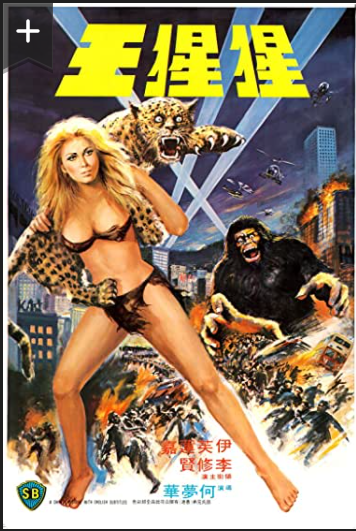
<Mighty Peking Man (Hsing hsing wang) (1977)>

In [447]:
movies.genre[movies.movie_id == title_to_id['Mighty Peking Man (Hsing hsing wang) (1977)']]

2533    Adventure|Sci-Fi
Name: genre, dtype: object

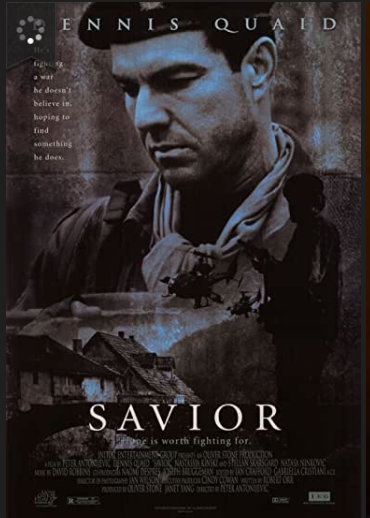
<Savior (1998)>

In [448]:
movies.genre[movies.movie_id == title_to_id['Savior (1998)']]

2289    Drama
Name: genre, dtype: object

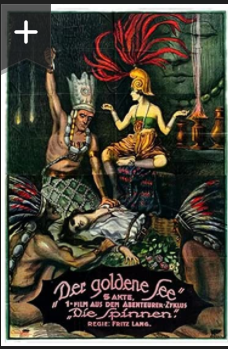
<Spiders, The (Die Spinnen, 1. Teil: Der Goldene See) (1919)>

In [449]:
movies.genre[movies.movie_id == title_to_id['Spiders, The (Die Spinnen, 1. Teil: Der Goldene See) (1919)']]

2754    Action|Drama
Name: genre, dtype: object

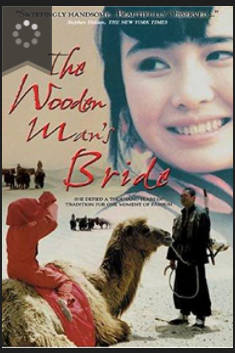
<Wooden Man's Bride, The (Wu Kui) (1994)>

#### 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [450]:
movie_recommended  = als_model.recommend(6041, csr_data, N=20, filter_already_liked_items=True)
movie_recommended 

[(1907, 0.20334749),
 (783, 0.16782415),
 (48, 0.118645996),
 (2664, 0.099332094),
 (661, 0.08522344),
 (2089, 0.08225017),
 (1301, 0.07971295),
 (3081, 0.07908314),
 (1920, 0.0734372),
 (2611, 0.071919076),
 (158, 0.07085968),
 (2353, 0.06906016),
 (2394, 0.068623),
 (100, 0.06802281),
 (2355, 0.06731594),
 (1346, 0.06677834),
 (2662, 0.066069424),
 (2365, 0.06568108),
 (3770, 0.06486515),
 (1687, 0.06482608)]

In [451]:
for idx, (i, j) in enumerate(movie_recommended):
    print(f'{idx+1}위({np.dot(my_vector,als_model.item_factors[i]):.2f}) : {id_to_title[i]}')

1위(0.20) : Mulan (1998)
2위(0.17) : Hunchback of Notre Dame, The (1996)
3위(0.12) : Pocahontas (1995)
4위(0.10) : Invasion of the Body Snatchers (1956)
5위(0.09) : James and the Giant Peach (1996)
6위(0.08) : Rescuers Down Under, The (1990)
7위(0.08) : Forbidden Planet (1956)
8위(0.08) : Sleepy Hollow (1999)
9위(0.07) : Small Soldiers (1998)
10위(0.07) : Winslow Boy, The (1998)
11위(0.07) : Casper (1995)
12위(0.07) : Enemy of the State (1998)
13위(0.07) : Prince of Egypt, The (1998)
14위(0.07) : City Hall (1996)
15위(0.07) : Bug's Life, A (1998)
16위(0.07) : Cat People (1982)
17위(0.07) : War of the Worlds, The (1953)
18위(0.07) : King Kong vs. Godzilla (Kingukongu tai Gojira) (1962)
19위(0.06) : Dreamscape (1984)
20위(0.06) : Jackal, The (1997)


#### 추가된 영화 장르 현황

In [452]:
data_movie.genre[data_movie.user_id == 6041]

17757                             Animation|Children's
29124                  Children's|Drama|Fantasy|Sci-Fi
32417    Adventure|Animation|Children's|Comedy|Musical
74082                                     Drama|Sci-Fi
80331                                   Drama|Thriller
Name: genre, dtype: object

In [453]:
data_movie[data_movie.user_id == 6041]

,user_id,movie_id,count,title,genre
17757,6041,2687,5,Tarzan (1999),Animation|Children's
29124,6041,1097,5,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
32417,6041,1566,5,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical
74082,6041,1253,1,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi
80331,6041,3147,2,"Green Mile, The (1999)",Drama|Thriller


In [454]:
temp.iloc[0].genre

"Animation|Children's"

In [455]:
temp

,user_id,movie_id,count,title,genre
17757,6041,2687,5,Tarzan (1999),Animation|Children's
29124,6041,1097,5,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
32417,6041,1566,5,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical
74082,6041,1253,1,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi
80331,6041,3147,2,"Green Mile, The (1999)",Drama|Thriller


In [456]:
dir(temp.iloc[0].count)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [457]:
temp.iloc[0]['count']

5

In [458]:
genre_favorite = []
temp = data_movie[data_movie.user_id == 6041]
temp.index
for idx in range(len(temp.index)):
    genre_favorite.extend(temp.iloc[idx].genre.split('|')*temp.iloc[0]['count'])

Text(0.5, 1.0, 'Genre of My Movies')

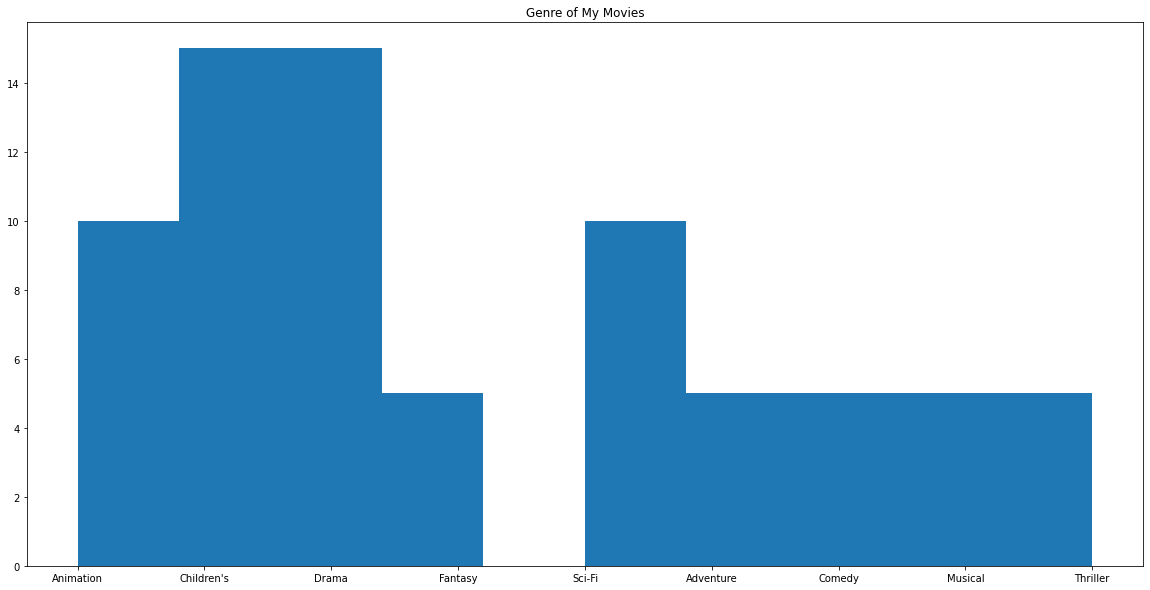

In [459]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,figsize = (20,10))
plt.hist(genre_favorite)
ax.set_title('Genre of My Movies')

- Children`s 와 Drama가 가장 많이 등장했고, 
- 그 다음으로, Animation과 Sci-Fi 장르가 등장했다

### Q. 추천에 가장 자주 등장하는 장르도  Children`s , Drama 일까?

### Answer 
- Children's가 가장 많이 등장
- 그 다음으로 등장한 것은 Animation과 Sci-Fi

In [460]:
genre_storage = []
for idx, (movie_id, j) in enumerate(movie_recommended): 
    genre_storage.extend(movies.genre[movies.movie_id==movie_id].values[0].split('|'))

Text(0.5, 1.0, 'Genre of Recommended Movies')

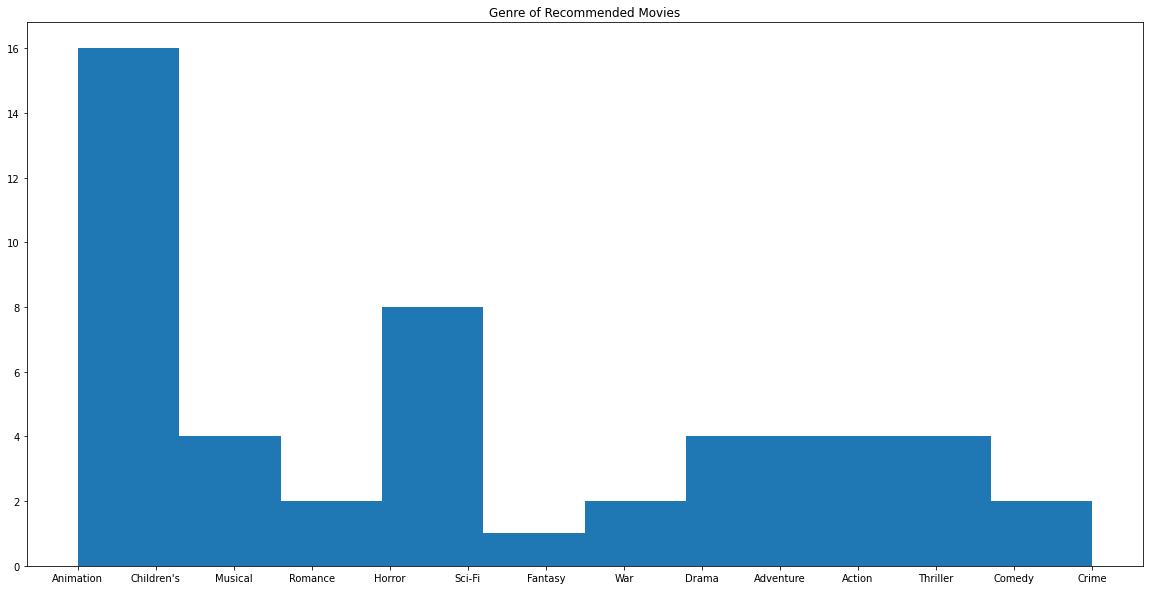

In [461]:
fig, ax = plt.subplots(1,figsize = (20,10))
plt.hist(genre_storage )
ax.set_title('Genre of Recommended Movies')

#### 기여도 확인

In [462]:
Mulan = title_to_id['Mulan (1998)']
explain = als_model.explain(6041, csr_data, itemid= Mulan)
explain

(0.2017331248245729,
 [(2687, 0.13135059919608993),
  (1566, 0.09273723769506953),
  (1097, -0.0026900901600785646),
  (1253, -0.008006786312881615),
  (3147, -0.011657835593626386)],
 (array([[ 0.43973864,  0.18351662,  0.20826199, ...,  0.19707719,
           0.20158809,  0.19100749],
         [ 0.08069935,  0.39835038,  0.13357573, ...,  0.1217552 ,
           0.12422922,  0.11615298],
         [ 0.09158084,  0.09142948,  0.39468162, ...,  0.10064746,
           0.10820657,  0.10137837],
         ...,
         [ 0.08666245,  0.08466817,  0.09703093, ...,  0.31654188,
           0.00172551,  0.00291919],
         [ 0.08864607,  0.08648152,  0.10128429, ...,  0.09601925,
           0.31443205, -0.00186389],
         [ 0.08399337,  0.08132263,  0.095307  , ...,  0.08909128,
           0.08942902,  0.31666329]]),
  False))

In [463]:
id_to_title[2687]

'Tarzan (1999)'

In [464]:
id_to_title[1566]

'Hercules (1997)'

In [465]:
id_to_title[1097]

'E.T. the Extra-Terrestrial (1982)'

In [466]:
id_to_title[3147]

'Green Mile, The (1999)'

In [467]:
id_to_title[1253]

'Day the Earth Stood Still, The (1951)'

- 내가 평점 5를 준 영화들이 나란히 기여도  1 ~ 3위를 기록
- 평점 2를 준 'Green Mile, The (1999)'이 기여도 4위
- 평점 2를 준 ''E.T. the Extra-Terrestrial (1982)'이 기여도 5위